In [2]:
%matplotlib inline
#
from os import chdir, getcwd
ROOTF = 'LRG-Signed'
if getcwd()[-len(ROOTF):] != ROOTF:
    chdir('../')
print('cwd:', getcwd())
#
from src.LRGSG_package.LRGSG import *

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


$\dot{x}(t) = -\bar{L}x(t)$<br>
$x(t+\Delta t) = x(t) - \Delta t\bar{L}x(t)$<br>
$y(t) = e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = e^{-\lambda_0 t}\dot{x}(t) -\lambda_0e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = -e^{-\lambda_0 t}\bar{L}x(t) -\lambda_0e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = -(\bar{L} + \lambda_0)y(t)$<br>
$y(t+\Delta t) = y(t)  -\Delta t(\bar{L} + \lambda_0)y(t)$

### Coordinates mapping between flat and bidimensional graph node indexing
Mapping between $2D$ coordinates of the NetworkX grid $\mathcal{G}$ and $\mathbb{N}^+$ labeled version $\mathcal{H}$, either in absence of BC and with PBC.

In [3]:
# parameters
initial_cond = 'gauss_1'
BC_choice = 'PBC'
#
L = 100
t_steps = 10
no_obs = 5
fbc_val = 1
#
Deltat = 1/t_steps
simulationTime = L**2*t_steps
sampling = 1*t_steps
frames = simulationTime // sampling
#
frames_dynsys = []

In [4]:
neg_weightsG = {((L//2,L//2), (L//2,L//2+1)): -1}
# neg_weightsH = {(0, 10): -1}
fraction_to_flip = 0.07
#
G = nx.grid_2d_graph(L, L, periodic=True)
nx.set_edge_attributes(G, values=1, name='weight')
nx.set_edge_attributes(G, values=neg_weightsG, name='weight')
# flip_random_fract_edges(G, fraction_to_flip)
H = nx.convert_node_labels_to_integers(G)
# nx.set_edge_attributes(H, values=neg_weightsH, name='weight')
#
neighbor_dictG = nx.single_source_shortest_path_length(G, (0, 0))
neighbor_dictH = nx.single_source_shortest_path_length(H, 0)
#
Gedges = list(G.edges(data=True))
neg_weightsG = [i for i in Gedges if i[2]['weight'] == -1]
Hedges = list(H.edges(data=True))
neg_weightsH = [i for i in Hedges if i[2]['weight'] == -1]
#
print('Flipped edges:', '\nG graph', neg_weightsG, '\nH graph', neg_weightsH, '[+ G negative edges]')

Flipped edges: 
G graph [((50, 50), (50, 51), {'weight': -1})] 
H graph [(5050, 5051, {'weight': -1})] [+ G negative edges]


In [5]:
node_map = dict(zip(H, G))
edge_map = dict(zip(H.edges(), G.edges()))

In [7]:
# laplacian and signed laplacian matrix
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)
# eigv, eigV = scipy.sparse.linalg.eigsh(slaplacian_matrix(G).astype(np.float64), k=1, which='SM')

In [9]:
if initial_cond == 'uniform_1':
    status_array = np.random.uniform(-1, 1, L**2)#np.ones(L**2)
elif initial_cond == 'delta_1':
    status_array = np.zeros(L**2)
    status_array[L**2//2] = L**2
elif initial_cond == 'gauss_1':
    status_array = np.random.normal(0, 1, L**2)
elif initial_cond.startswith('ground_state'):
    eigenMode = int(initial_cond.split('_')[-1])
#
if BC_choice == 'FBC':
    # fixed_border_idxs = np.array(list(set(
    #                   np.concatenate([[i for i in range(L)], 
    #                         [i for i in range(L**2) if i % L ==0], 
    #                         [i for i in range(L**2) if (i+1) % (L) ==0],
    #                         [i for i in range(L**2-L, L**2)]]))))
    fixed_border_idxs = np.array(sorted([i for i in range(L)] + \
                [(L-1) * L + i for i in range(L)] + \
                [i * L for i in range(1, L-1)] + 
                [(i+1) * L - 1 for i in range(1, L-1)]))
    status_array[fixed_border_idxs] = fbc_val

In [10]:
# status_array = status_array/status_array.sum()
for t in range(300):
    status_array_old = status_array
    if (t % sampling == 0):
        print(t, np.mean(status_array), np.var(status_array))
        frames_dynsys.append(status_array_old.reshape(L, L))
    status_array = status_array - Deltat*((slapl - eigv[0])@status_array) #+ np.sqrt(Deltat)*np.random.uniform(-1e-3, 1e-3, L**2)
    if BC_choice == 'FBC':
        status_array[fixed_border_idxs] = fbc_val
    # if (np.abs(status_array_old - status_array) < 1e-7*np.ones(L**2)).all():
    #     print('Convergence rea\ched')
    #     break

0 -0.0015078385601650908 0.9833659536835705
10 -0.004582240495208488 0.03892208276673075
20 -0.013063842456882333 0.018570366251373434
30 -0.037059787910744664 0.01190596286136539
40 -0.10502333251187942 0.0086454065890345
50 -0.29754069128178023 0.006736597869749052
60 -0.8428894364095986 0.005521803502565999
70 -2.3877217416304966 0.004871880946918915
80 -6.7638402497047965 0.005858896230521395
90 -19.16028087328322 0.01795825925690509
100 -54.27627689330877 0.11725328811123989
110 -153.75105841434757 0.9131822179324514
120 -435.5380896377881 7.292540412694304
130 -1233.7698626489464 58.45909724782025
140 -3494.959674334576 468.97451782278426
150 -9900.341593313298 3762.952980461991
160 -28045.177254499602 30194.85577326454
170 -79444.93223328411 242295.32783219652
180 -225047.5081527154 1944284.1581691154
190 -637502.9784791176 15601821.743816443
200 -1805885.5701200156 125196209.59011917
210 -5115619.538176298 1004632327.1608366
220 -14491263.28507791 8061635366.275674
230 -4105010

In [16]:
status

array([[0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002],
       [0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002],
       [0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002],
       ...,
       [0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002],
       [0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002],
       [0.00010002, 0.00010002, 0.00010002, ..., 0.00010002, 0.00010002,
        0.00010002]])

In [32]:
status = status_array.reshape(L, L)/status_array.sum()
halfsize = L//2
hcut_halfsize = status[halfsize, :]
vcut_halfsize = status[:, halfsize]
critrad = np.sqrt(1.128/(3.14*0.103))
ball_halfsizeM = halfsize+1-critrad
ball_halfsizeP = halfsize+1+critrad

In [33]:
critrad, 1/critrad

(1.8675451640340275, 0.5354622845318131)

/tmp/ipykernel_14465/378736525.py:16: RuntimeWarning: divide by zero encountered in log10
  phi_plot = np.log10(np.max(status)-status)


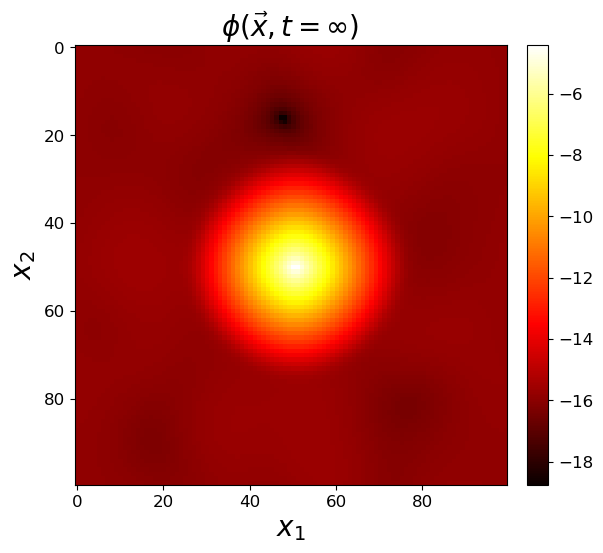

In [35]:
plt.rc('font', size=12)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
cax_dict = {"size": "5%", "pad":0.2}
axvline_cr = {"ls": ":", "color": "red"}
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(7.5, 7))
#


ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_title(r"$\phi(\vec{x}, t=\infty)$")
#
phi_plot = status
phi_plot = np.log10(np.max(status)-status)
phi_plot_nnans = phi_plot[(phi_plot != np.inf) & (phi_plot != -np.inf)]
phi_plot = np.nan_to_num(phi_plot, posinf=np.max(phi_plot_nnans), neginf=np.min(phi_plot_nnans))
im1 = ax1.imshow(phi_plot, cmap=plt.cm.hot, aspect="auto")
#
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", **cax_dict)
clb = fig.colorbar(im1, cax=cax)
#
#
# circ = Circle((L//2,L//2),critrad, alpha=0.5, lw=2)
# ax1.add_patch(circ)
# circ = Circle((L//2,L//2),25, ls='--', lw=1, color='k', fill=False)
# ax1.add_patch(circ)
# circ = Circle((L//2,L//2),1.0187186, alpha=0.5, lw=2, color='red')
# ax1.add_patch(circ)

fig.tight_layout(pad=5.0)
fig.savefig(r"ball.pdf", bbox_inches='tight', transparent=True
            )

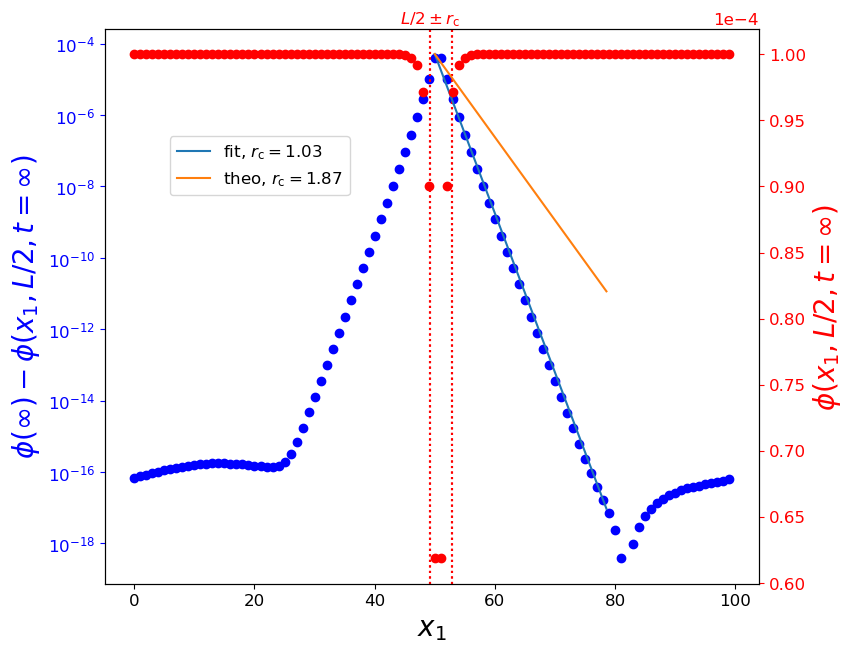

In [26]:
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((-7,-2))  

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.set_xlabel("$x_1$")
ax2.set_ylabel(r"$\phi(\infty) - \phi(x_1, L/2, t=\infty)$", color='blue')
#
ax2.plot(np.max(hcut_halfsize)-hcut_halfsize, 'bo')
# ax2.plot(np.max(vcut_halfsize)-vcut_halfsize, 'o')
ax3 = ax2.twinx()
ax3.plot(hcut_halfsize, 'ro')
# ax3.set_yticklabels([])
ax2.axvline(ball_halfsizeM, **axvline_cr)
ax2.axvline(ball_halfsizeP, **axvline_cr)
#
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", **cax_dict)
cax2.axis('off')
#
trans = ax2.get_xaxis_transform()
ax2.text(ball_halfsizeM, 1.01, r'$L/2 \pm r_{\rm c}$', color='red', horizontalalignment='center', transform=trans)

ax3.set_ylabel(r"$\phi(x_1, L/2, t=\infty)$", color='red')

ax3.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
ax3.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')
#
ax2.set_yscale('log')
# aspect_ratio = ax1.get_data_ratio() / ax2.get_data_ratio()
# box_ratio = 1.0
# ax2.set_aspect(aspect_ratio)
# ax1.set_xlim([30, 70])
# ax1.set_ylim([30, 70])

phi_asym = np.max(hcut_halfsize) - hcut_halfsize[L//2:]
x = np.linspace(0, len(phi_asym), num=len(phi_asym))

idx = np.where(phi_asym < 1e-17)[0][0]
params, cov = curve_fit(line, x[:idx], np.log(phi_asym[:idx]))


ax2.axvline(ball_halfsizeM, **axvline_cr)
ax2.axvline(ball_halfsizeP, **axvline_cr)
# plt.plot(x, phi_asym, 'o')
ax2.plot(x[:idx]+50, np.exp(line(x[:idx], *params)), label=rf"fit, $r_{{\rm c}} = {np.abs(params[0]):.2f}$")
ax2.plot(x[:idx]+50, np.exp(line(x[:idx], -1/(critrad), params[1])), label=rf"theo, $r_{{\rm c}} = {critrad:.2f}$")
ax2.legend(loc=[0.1, 0.7])
fig.tight_layout(pad=5.0)
fig.savefig(r"fit.pdf", bbox_inches='tight', transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


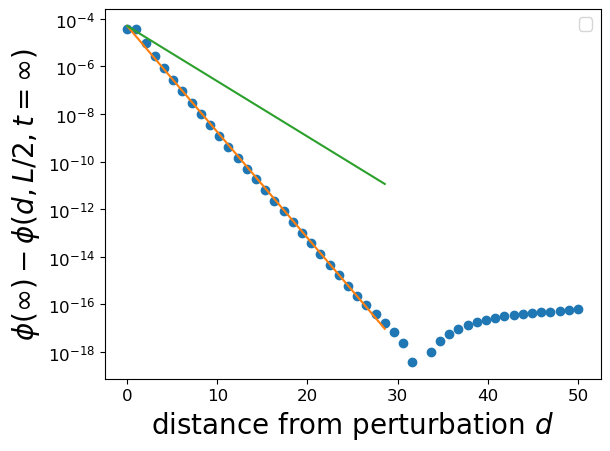

In [43]:
def decay_linear(x, a, b):
    return a * x + b
def line(x, a, b):
    return decay_linear(x, a, b)
def decay_exp(x, a, b, c, d):
    return a*(1-np.exp(-b * (x-d))) + c

phi_asym = np.max(hcut_halfsize) - hcut_halfsize[L//2:]
x = np.linspace(0, len(phi_asym), num=len(phi_asym))

idx = np.where(phi_asym < 1e-17)[0][0]
params, cov = curve_fit(line, x[:idx], np.log(phi_asym[:idx]))

plt.plot(x, phi_asym, 'o')
plt.plot(x[:idx], np.exp(line(x[:idx], *params)))
plt.plot(x[:idx], np.exp(line(x[:idx], -1/(critrad), params[1])))
# plt.plot(x, decay_exp(x, phi_asym[-1]-phi_asym[0], 1/critrad, phi_asym[0], 25), label=r'$\propto e^{d/r_{\rm c}}$')
# plt.plot(x, decay_exp(x, phi_asym[-1]-phi_asym[0], 1/critrad, phi_asym[0], 25), label=r'$\propto e^{d/r_{\rm c}}$')
# plt.axhline(hcut_halfsize[60])
plt.yscale('log')
plt.xlabel(r"distance from perturbation $d$")
plt.ylabel(r"$\phi(\infty) - \phi(d, L/2, t=\infty)$", color='black')
plt.legend()

In [39]:
1/params, -1/critrad

(array([-0.97456101, -0.10112888]), -0.5354622845318131)

In [69]:
params, critrad/2

(array([-1.0187186 , -9.98226032]), 0.9337725820170137)

In [40]:
1/params[0], -1/(critrad)

(-0.9745610057485569, -0.5354622845318131)

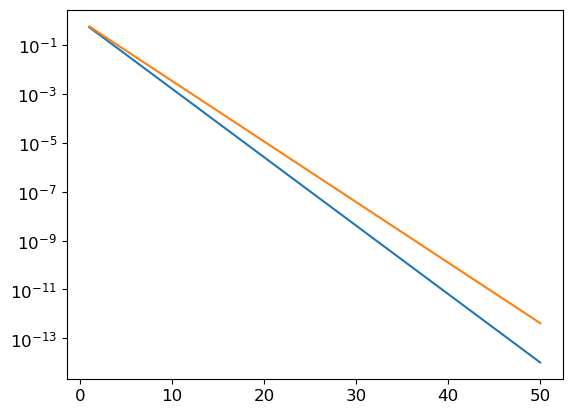

In [185]:
x = np.linspace(1, 50)
exp1 = np.exp(-0.644*x)
exp2 = np.exp(-0.57*x)
plt.plot(x, exp1)
plt.plot(x, exp2)
plt.yscale('log')

In [32]:
(hcut_halfsize[40])*np.exp(-(x)/critrad)

array([3.92032791e+10, 3.87772057e+10, 3.83557630e+10, 3.79389006e+10,
       3.75265689e+10, 3.71187185e+10, 3.67153007e+10, 3.63162675e+10,
       3.59215710e+10, 3.55311642e+10, 3.51450005e+10, 3.47630338e+10,
       3.43852183e+10, 3.40115091e+10, 3.36418615e+10, 3.32762313e+10,
       3.29145749e+10, 3.25568491e+10, 3.22030111e+10, 3.18530188e+10,
       3.15068303e+10, 3.11644043e+10, 3.08256999e+10, 3.04906766e+10,
       3.01592945e+10, 2.98315139e+10, 2.95072958e+10, 2.91866013e+10,
       2.88693923e+10, 2.85556308e+10, 2.82452793e+10, 2.79383009e+10,
       2.76346588e+10, 2.73343167e+10, 2.70372389e+10, 2.67433898e+10,
       2.64527343e+10, 2.61652378e+10, 2.58808659e+10, 2.55995846e+10,
       2.53213604e+10, 2.50461600e+10, 2.47739506e+10, 2.45046996e+10,
       2.42383749e+10, 2.39749447e+10, 2.37143776e+10, 2.34566424e+10,
       2.32017083e+10, 2.29495449e+10])

In [110]:
rcorr = np.array(radial_correlation(status_array-status_array[0], neighbor_dictH, 5050))

In [119]:
morans = []
for i in range(len(status_array)):
    morans.append(local_moran_i(5050, status_array, adj))

Text(0, 0.5, 'corr')

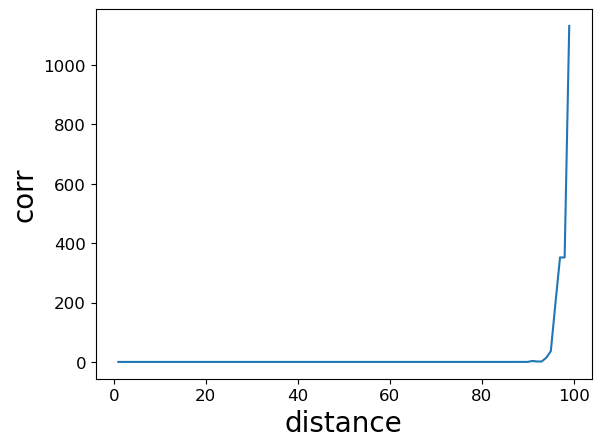

In [115]:
plt.plot(rcorr[:, 0], rcorr[:, 1])
plt.xlabel('distance')
plt.ylabel('corr')
# plt.xscale('log')


________________________________________________________________________________

In [1]:
L = 20
neg_weights = {((2,2), (2,3)): -1}

G = nx.grid_2d_graph(L, L, periodic=True)
nx.set_edge_attributes(G, values=1, name='weight')
# nx.set_edge_attributes(G, values=neg_weights, name='weight')
#oppure
fraction_to_flip = 0.09
flip_random_fract_edges(G, fraction_to_flip)
H = nx.convert_node_labels_to_integers(G)

NameError: name 'nx' is not defined

In [87]:
# laplacian and signed laplacian matrix
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)

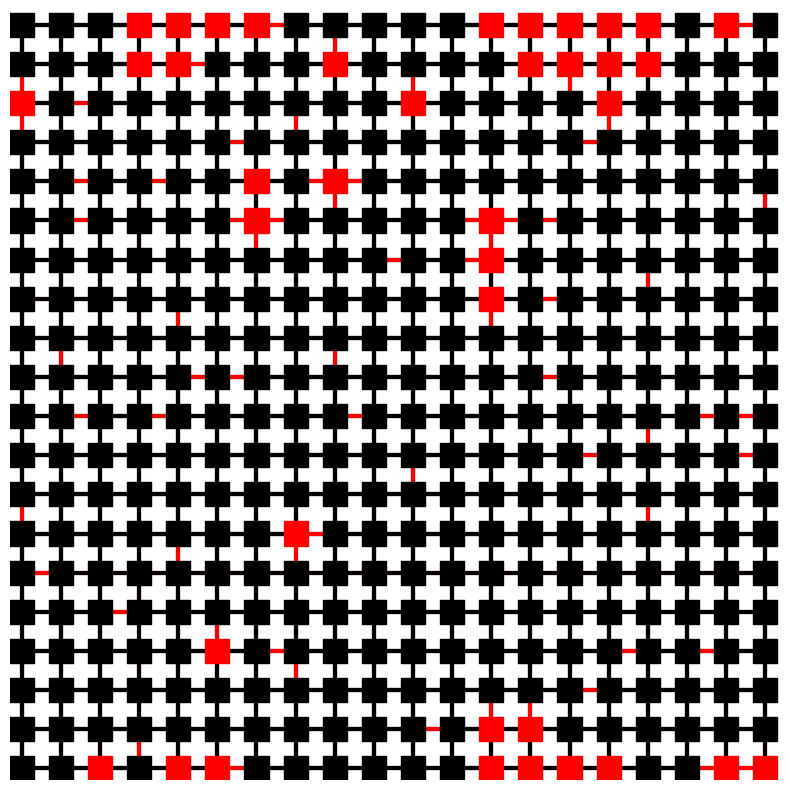

In [88]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
fig, ax1 = plt.subplots(ncols=1, figsize=(8, 8))
posH = {i:(x, y) for i,(x,y) in enumerate(product(range(L), range(L)))}
posG = {(x, y):(x, y) for i,(x,y) in enumerate(product(range(L), range(L)))}
node_color = ['red' if eigV[i,0] > 0 else 'black' for i in H.nodes()] 
Gedges = list(G.edges(data=True))
Hedges = list(H.edges(data=True))
edge_colorH = ['red' if d['weight'] == -1 else 'black' for u,v,d in Hedges]
edge_colorG = ['red' if d['weight'] == -1 else 'black' for u,v,d in Gedges]
nx.draw(H, node_color=node_color, pos=posH, ax=ax1, edge_color = edge_colorH, width=3, node_shape="s")

# nx.draw(G, node_size=70, node_color=node_color, pos=posG, edge_color = edge_colorG,  width=3, ax=ax1)
fig.patch.set_alpha(0)

cut = 1.02
xmax= cut*max(xx for xx,yy in posG.values())
ymax= cut*max(yy for xx,yy in posG.values())
ax1.set_xlim(-0.3,xmax)
ax1.set_ylim(-0.3,ymax)
fig.tight_layout()
fig.savefig("out.pdf")

In [64]:
node = 0

# Set the desired order
order = 1

# Get the kth-order neighbors
neighbor_dict = nx.single_source_shortest_path_length(G, node, cutoff=order)
# Extract the nodes at the kth order
kth_order_neighbors = [n for n, d in neighbor_dict.items() if d == order]
kth_order_neighbors

NodeNotFound: Source 0 is not in G

In [41]:
# L = 1000
# field_array = np.random.rand(L, L)
# # Compute Local Moran's I for each cell in the field array
# local_moran = np.zeros_like(field_array, dtype=float)
# for i in range(field_array.shape[0]):
#     for j in range(field_array.shape[1]):
#         local_moran[i, j] = local_moran_i(field_array, i, j)

# # Print the local Moran's I values for each cell
# print(np.mean(local_moran)/L**2)
# field_array